# AB-testing by clusters

## How to run experiments on small data sets
[Bertil Hatt](https://www.linkedin.com/in/bertilhatt/) & [João F. Martins](https://www.linkedin.com/in/joão-fidalgo-martins-8837b07a
) — [Farfech](https://www.farfetchtechblog.com/en/)

## This presentation is relevant if you are curious about:
- AB-tests _aka_ Double-blind randomised control trials (RCT)
- Python code running such tests in general
- specificially on small samples, for instance:
  - Medical treatment at the experimental phase, _i.e._ with few patients
  - New company or B2B, platform, market place structure with few clients
  - External constraints, _e.g._ over-the-line (OTL), enrollment, relations between clients

Constraints are often expressed as *clusters* of observations.  
Another name for that pattern is *quasi-experiments*.

## Contents
<a name="contents_1"></a>

[Motivation](#intro)  
[I. How to run a test](#principles)  
[_Generate random samples_](#random_generation)  
[II. Process results](#code)  
[III. AA-tests](#aa_test)  
[IV. Sensitivity testing](#sensitivity)  
[V. Process the source dataset](#source_data)  
[VI. Complications](#unit_selection)  
[_Summary_](#summary)

# Why run experiments when you have small samples
<a name="intro"></a>


## Why AB tests (in general)?

Measuring the impact of a change
- When circumstances changes your objectives
- Multiple simultaneous interfering tests
- Explicit precision over impact measure

## Use cases with small samples
- Early clinical tests with few patients
- New company, B2B with few partners
  - Multi-sided market, sides with few large blocks
- Quasi experiment _aka_ Experiment by cluster

## Does it make sense to test on small sample?
  - Yes but tests have **low power** _i.e._ can only detect large impact
  - Manage stakeholders’ expectations, Monitor segmentation

### Running, open, free to use code and some equations

This presentation and the notebook it is based on is freely available on-line. It contains some equations (for the $t$-test) and a lot of Python code — enough to run full AB-test analysis.

All the code that you need will appear on the screen. The code runs on Python 3.x and basic PyData libraries (`pandas`, `numpy`, `copy`, `math`, `scipy.stats`, `matplotlib.pyplot`, `datetime`).

The code in most cells should take less time to run than for us to make the presentation. There’s a handful of exception with a `Warning` comment letting you know some lines takes minutes to compute.

We encourage you to download the notebook, follow along, execute cells as we go, modify and **ask questions about things you can change**.

# I. How to run a test
<a name="principles"></a>

## Define your experiment

### Population, treatment, objective metric, minimum relevant impact
- Define population, isolate independent units (users)
- Clarify your segments: Control _vs._ Treatment
- Specify your Objective metric
  - in this presentation, we have simplified it to a conversion rate of two integers: Conversions over Observations 
- Relevant impact: Minimum detectable effect and Expected duration

### Statistical test – Simplified

We estimate the Conversion rate for control and treatment in their respective sample.

$$ \hat{{CR}_C} = \frac{\#conv_C}{\#obs_C} \quad \hat{{CR}_T} = \frac{\#conv_T}{\#obs_T}$$ 

the variance of the conversion rate for control is:
$$ \hat{V} \left({CR}_C\right) = \frac{\hat{{CR}_C}(1-\hat{{CR}_C})}{\#obs_C} $$

We consider the estimates on Control and Treatment to be independent,  
therefore the theoretical variance for their difference is :
$$ V \left(d_{C-T}\right) =
   V \left(CR_T - CR_C\right) =
\frac{{CR}_C(1-{CR}_C)}{\#obs_C} + \frac{{CR}_T(1-{CR}_T)}{\#obs_T} $$

and the estimated standard deviation is:
$$ \hat\sigma\left(d_{C-T}\right) =
\sqrt{\frac{\hat{CR_C}(1-\hat{CR_C})}{\#obs_C} +
      \frac{\hat{CR_T}(1-\hat{CR_T})}{\#obs_T}} $$

### Statistical test – Simplified (Continued)

We consider the difference to be **significant** by proving unlikely the hypothesis of No difference, specifically:
- if we assume Control and Treatment are the same,
- would the difference only happen in the most eggregious cases, say 5%?

  _i.e._ Is the difference in conversion rate **outside of the confidence interval** for Control?

For $\alpha = \: 5\%$, that means $ z_{1-\alpha/2} = 1.96 $ standard deviations on either side of the estimate.  
For $\alpha = 10\%$, that means $z_{1-\alpha/2} = 1.65$.

$$ \hat{d}_{C-T} \in \left[ 0 \pm z.\hat\sigma\left(d_{C-T}\right)\right] $$

### Minimal detectable effect

Given $p_C = \hat{CR_C}, p_T = \hat{CR_T} $ and an agreed $z$, the **minimal detectable effect** (MDE) is

$$ \begin{align}
MDE & = z.\hat\sigma(d_{C-T}) \\
& = z \sqrt{\frac{p_C(1-p_C)}{\#obs_C}+\frac{p_T(1-p_T)}{\#obs_T}}
\end{align}$$

Therefore, assuming that we have
- balanced segments ($\#obs_C \approx \#obs_T$) and
- a rough estimation $p$ of $p_C$ and $p_T$

we can compute how many observations are needed for a test to reach a relevant minimal detectable effect:

$$ \begin{align}
MDE \quad \approx & \quad z \sqrt{2 \frac{p(1-p)}{\#obs_C}} \\
\#obs_C \quad \approx  & \quad 2 p(1-p)\left(\frac{z}{MDE}\right)^2 \\
\#obs \quad = \quad \#obs_T + \#obs_C \quad \approx & \quad 4 p(1-p)\left(\frac{z}{MDE}\right)^2
\end{align}$$

The expected test **duration** is inferred from the expected traffic.

For a MDE twice more refined, you’ll need four times more observations, _i.e._ wait four times longer. 

### Test statistics

We can also express the test with a $t$-score and a $p$-value: 

- the $t$-score is the number of standard deviation observed, _i.e._ $$ t = \frac{\hat{d_{C-T}}}{\hat{\sigma}\left(d_{C-T}\right)} $$
- the $p$-value is the probability that our data would be at least this inconsistent given our hypothesis. It’s typically computed using known $t$-test distributions dependent of the degrees of freedom of the test, _i.e._ the sample. If $p < \alpha$, we accept the test as signficant.

Those correspond to a frequentist test. If you want to contribute to this repository and presentation by submitting a Bayesian tests to replace `TTest`, you are more than welcome to do so.

### Caveat

We are assuming that:
1. we observe at most one conversion per observation;
  - This is not true for test on non-binary quantities.
  
1. there are enough observations in total and;
1. the conversion rate is far enough from zero  
   for a Bernoulli sample to be assumed Gaussian;
  - This is not true for very small samples.
1. each observation (and conversion) is independent;
  - This might not be true if events can be grouped.

Most of those assumptions will be challenged further down.  

# _Generate random samples_

<a name="random_generation"></a>

We need to create fake data for the purpose of this presentation.

_Feel free to skip if you use your own dataset._

### Generate random observations

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

def date_from_value(value, start = "2019-01-01", end = "2019-07-01"):
    """
    Given a value between 0 and 1,
    Returns a datetime between two dates (as string)
    """
    # TODO: more realistic time of day
    start = dt.datetime.strptime(start, '%Y-%m-%d')
    end = dt.datetime.strptime(end, '%Y-%m-%d')
    duration_sec = value * ((end - start).days*24*60*60)
    return start + dt.timedelta(seconds=duration_sec)

In [2]:
def generate_observation_and_conversion(
    conversion_rate = 0.3, nb_users= 400, nb_events = 1000,
    pareto_parameter_conversion_delay = .4,
):
    """
    Given parameters about a population,
    Returns a list of random events, with a possible conversion and delay
    """
    random_dates = pd.Series(np.random.random(size=(nb_events)))
    random_dates = random_dates.apply(date_from_value)
    random_users = pd.Series(np.random.randint(nb_users, size=(nb_events)))
    random_convs = pd.Series(np.random.rand(nb_events) < conversion_rate)
    random_conv_delay = pd.Series(np.random.pareto(
        pareto_parameter_conversion_delay, size=(nb_events)
    ))
    random_events = pd.concat([
        random_dates, random_users, random_convs, random_conv_delay,
    ], axis=1, sort=False)
    random_events.columns = \
        ["event_timestamp", "user_id", "conversion", "conversion_delay",]
    return random_events

In [3]:
random_events = generate_observation_and_conversion()
random_events.head()

,event_timestamp,user_id,conversion,conversion_delay
0,2019-06-19 19:35:04.882206,245,False,1.251711
1,2019-04-30 05:21:02.977743,137,False,1.188837
2,2019-04-20 05:52:06.137008,357,False,930.018653
3,2019-04-30 09:52:13.901161,242,False,15.796589
4,2019-03-26 18:56:14.258685,150,True,295.516417


In [4]:
def generate_conversion_from_observation(random_events):
    """
    Given a set of events with possible conversions
    Return the table of conversions
    """
    cols = [col for col in random_events.columns
            if col not in ("event_delay", "conversion", "conversion_delay")]
    conversions = random_events[random_events["conversion"]]
    if len(conversions) > 0:
        conversions = conversions.assign(
            event_timestamp = conversions.apply(
                lambda row: row["event_timestamp"] + dt.timedelta(
                    minutes=min(row["conversion_delay"], 24*60*60)
                    # If conversion_delay is too high, type can overflod
                ),
            axis=1))
    return conversions[cols]

In [5]:
random_convertions = generate_conversion_from_observation(random_events)
random_convertions.head(3)

,event_timestamp,user_id
4,2019-03-26 23:51:45.243693,150
6,2019-03-28 08:31:09.973290,363
8,2019-05-27 18:05:24.368896,84


In [6]:
def generate_events(cr=.3, n_obs=1_000, n_user=500, pp=.4):
    """
    Given optional key parameters about an set of events
    Return a sample set of events with observations and conversions
    """
    observation = generate_observation_and_conversion(cr, n_user, n_obs, pp)
    convertions = generate_conversion_from_observation(observation)
    observation = observation[["event_timestamp", "user_id"]]
    observation = observation.assign(event_type = "observation")
    convertions = convertions.assign(event_type = "conversion")
    events = pd.concat([observation, convertions], axis=0)    
    events = events.sort_values(by=["event_timestamp"]).reset_index(drop=True)
    return events

In [7]:
events = generate_events()
events.head()

,event_timestamp,user_id,event_type
0,2019-01-01 00:30:27.751299,117,observation
1,2019-01-01 00:36:26.849425,117,conversion
2,2019-01-01 01:27:55.068509,389,observation
3,2019-01-01 01:29:18.171929,389,conversion
4,2019-01-01 10:05:54.460814,319,observation


In [8]:
segments = ["control", "treatment"]
def generate_segment(events, segments=segments, cluster="user_id"):
    """
    Given events and an optional list of alternative options
    Returns balanced assignement to each segment
    """
    creation = events.groupby(cluster)["event_timestamp"].min()
    creation = pd.DataFrame(creation)    
    assignment = np.random.choice(segments, len(creation))
    creation = creation.assign(segment = assignment)
    creation.columns = ["assignment_timestamp", "segment"]
    return creation

In [9]:
segment = generate_segment(events)
segment.head()

,assignment_timestamp,segment
user_id,,
0,2019-04-10 01:39:36.340441,control
1,2019-05-24 12:54:17.708060,control
2,2019-04-03 09:42:53.590793,control
3,2019-04-26 08:22:30.371735,treatment
4,2019-03-27 22:35:33.181363,control


# II. Processing results

<a name="code"></a>

## Aggregating and testing significance

In [10]:
events = generate_events()           # load from database
segment = generate_segment(events)   # randomised in prod
events_with_segment = events.set_index("user_id")\
                     .join(segment, on="user_id")
events_with_segment["user_id"] = events_with_segment.index
totals = events_with_segment\
    .groupby(["segment", "event_type"])["user_id"].nunique()

In [11]:
totals

segment    event_type 
control    conversion     105
           observation    199
treatment  conversion     101
           observation    227
Name: user_id, dtype: int64

We always want to use a metric that is a ratio over the attribution unit. Otherwise, correlation with engagement and conversion [bias our measurement](https://towardsdatascience.com/the-second-ghost-of-experimentation-the-fallacy-of-session-based-metrics-fb65006d30ff).

Let’s turn that into a function.

In [12]:
def compute_totals(events, segment, unit="user_id", cluster="user_id"):
    events_with_segment = events.set_index(cluster)\
        .join(segment, on=cluster)
    if events_with_segment.index.name == unit:
        events_with_segment[unit] = events_with_segment.index
    totals = events_with_segment \
        .groupby(["segment", "event_type"])[unit].nunique()
    return totals

In [13]:
events = generate_events()
segment = generate_segment(events)
totals = compute_totals(events, segment)
totals

segment    event_type 
control    conversion     100
           observation    193
treatment  conversion     129
           observation    231
Name: user_id, dtype: int64

How can we tell if the difference between the two conversion rates is significant?

First, we need to decide when a value is outside of a confidence interval.

In [14]:
from scipy.stats import norm, t
alpha = .1

def var_cr(segment):
    if segment.observation > 0:
        cr = segment.conversion / segment.observation
        var = cr*(1-cr)/segment.observation
        return var, cr
    else:
        return None

def beat_conf_interval(value, conf_interval):
    if value < conf_interval[0]:
        result = "Loose"        
        significant = True
    else:    
        if value > conf_interval[1]:
            result = "Win"
            significant = True
        else:
            result = "Draw"        
            significant = False
    return significant, result

And apply that distinction to a new class.

In [15]:
class TTest():
    def __init__(self, totals, alpha=alpha):
        self.totals = totals
        self.alpha = alpha
    def compute(self):
        co = self.totals.control
        tr = self.totals.treatment
        self.observation = co.observation + tr.observation
        var_c, self.cr_c = var_cr(co) 
        var_t, self.cr_t = var_cr(tr)
        # Stats
        self.difference = self.cr_t - self.cr_c
        self.rel_diff = self.difference/self.cr_c
        self.stddev = np.sqrt(var_c + var_t)
        self.z = norm.interval(1-self.alpha)
        self.conf_interval = tuple(i*self.stddev for i in self.z)
        # Results
        self.significant, self.result = \
            beat_conf_interval(self.difference, self.conf_interval)    
        self.t = self.difference/self.stddev
        self.p = 1 - t.cdf(self.t, df=self.observation -2)        
        return self.significant

Let’s check what that looks like for the `totals` that we just computed.

In [16]:
t_test = TTest(totals)
t_test.compute()
vars(t_test)

{'totals': segment    event_type 
 control    conversion     100
            observation    193
 treatment  conversion     129
            observation    231
 Name: user_id, dtype: int64,
 'alpha': 0.1,
 'observation': 424,
 'cr_c': 0.5181347150259067,
 'cr_t': 0.5584415584415584,
 'difference': 0.040306843415651716,
 'rel_diff': 0.07779220779220782,
 'stddev': 0.048591136450340154,
 'z': (-1.6448536269514729, 1.6448536269514722),
 'conf_interval': (-0.07992530702803592, 0.07992530702803588),
 'significant': False,
 'result': 'Draw',
 't': 0.8295102020683354,
 'p': 0.2036423679980155}

Let’s represent that result in a more legible way.

In [17]:
def format_ci(ci, sep=' '):
    return sep.join(format(lim, '.1%') for lim in ci)

def format_decision(self):
    str = "Our metric went from {0:.1%} to {1:.1%}, ".format(self.cr_c, self.cr_t)
    str += "a difference of {0:.1%}.\n".format(self.difference)
    str += "Our Minimal detectable effect (MDE) is "
    str += "{0:.1%}.\n".format(self.conf_interval[1])
    str += "The absolute difference is " + ("larger" if self.significant else "smaller") 
    str += " and" + (("" if self.significant else " not") + " significant.")
    return str
TTest.format_decision = format_decision

In [18]:
print(t_test.format_decision())

Our metric went from 51.8% to 55.8%, a difference of 4.0%.
Our Minimal detectable effect (MDE) is 8.0%.
The absolute difference is smaller and not significant.


## Basic classes

<a name="classes"></a>


In [19]:
class ABTest:
    def __init__(self, events, segment,
                 unit=segment.index.name,
                 cluster=segment.index.name):
        self.events = events
        self.segment = segment
        self.unit = unit
        self.cluster = cluster
    def compute(self):
        self.totals = compute_totals(
            self.events, self.segment,
            unit=self.unit, cluster=self.cluster)        
        self.t_test = TTest(self.totals)
        self.t_test.compute()
        self.decision = self.t_test.format_decision()
        return self.t_test.significant

In [20]:
ab_test = ABTest(events, segment)
ab_test.compute()
ab_test.totals

segment    event_type 
control    conversion     100
           observation    193
treatment  conversion     129
           observation    231
Name: user_id, dtype: int64

In [21]:
print(ab_test.decision)

Our metric went from 51.8% to 55.8%, a difference of 4.0%.
Our Minimal detectable effect (MDE) is 8.0%.
The absolute difference is smaller and not significant.


### Size-dependent results

A test on a larger sample can detect more refined effects.

In [22]:
def test_sample_by_size(n_obs=1_000):
    events = generate_events(n_obs=n_obs, n_user=n_obs/2)
    ab_test = ABTest(events, generate_segment(events))
    ab_test.compute()
    print(ab_test.decision)

In [23]:
test_sample_by_size(n_obs=1_000)

Our metric went from 54.9% to 51.3%, a difference of -3.6%.
Our Minimal detectable effect (MDE) is 7.9%.
The absolute difference is smaller and not significant.


In [24]:
test_sample_by_size(n_obs=10_000)

Our metric went from 52.2% to 52.8%, a difference of 0.6%.
Our Minimal detectable effect (MDE) is 2.5%.
The absolute difference is smaller and not significant.


In [25]:
test_sample_by_size(n_obs=100_000)

Our metric went from 52.1% to 52.6%, a difference of 0.6%.
Our Minimal detectable effect (MDE) is 0.8%.
The absolute difference is smaller and not significant.


### Sequential tests

Running test for increasingly longer should improve precision. But running the test **repeatedly** while accumulating more data, and acting on any significant result means that we **compound the probability of false positives**.

We can reduce the false positive rate for each individual test to a value that compounds up to our desired $\alpha$. This is known as the Sequential Probability Ratio Test (SPRT) We have implemented a sequential approach known as the modified SPRT or **mSPRT**.

For details, see [a recent paper by Etsy](https://www.hongliangjie.com/publications/wsdm2019_preprint.pdf)

# III. AA-tests

<a name="aa_test"></a>

## Why run AA-tests

Is the test detecting non-changes?

### Confusion matrix

|        _             | Actual difference | No real difference  |
| -------------------- |:-----------------:|:------------------- |
| **Test signficant**  | True positive     | False positive      |
| **Test non-signif.** | False negative    | True negative       |


We don’t know how much of a change a treatment will actually bring: “significant” is contextual.

It’s simpler to test a non-difference, using past data based before we introduced a change and spliting it in half randomly.

If we test those two (presumably equivalent) halves, we shouldn’t detect a difference. In practice, they might. We can then check how frequent are false positives, _i.e._ tests that wrongly appear significant.

|        _      | *Actual difference* |  No real difference |
| ------------- |:-------------------:|--------------------:|
| Test positive | *True positive*     | **False positive**  |
| Test negative | *False negative*    | True negative       |


### How to run an AA tests

#### Random split and test, repeatedly

- Collect recent relevant data

- Split segments randomly (fairly)

- Test that distinction without a difference

In [26]:
class BatchAATest:
    def __init__(self, events, unit="user_id", cluster="user_id"):
        self.events = events
        self.unit = unit
        self.cluster = cluster
    
    def test_with_random_segment(self):
        self.segment = generate_segment(
            self.events, cluster=self.cluster)
        self.test = ABTest(
            self.events, self.segment,
            unit=self.unit, cluster=self.cluster)
        self.test.compute()
        return self.test
    
    def run_steps(self, n_runs=100):
        self.results, self.list_t, self.list_p = [], [], []
        for j in range(n_runs):
            self.test_with_random_segment()
            self.results.append(self.test.t_test.significant)
            self.list_t.append(self.test.t_test.t)
            self.list_p.append(self.test.t_test.p)
        return self.results

We count the $k$ false positives over $n$ AA-tests, like $k$ conversions over $n$ observations.  
We also compute the distribution of $t$-values and $p$-scores.

In [27]:
def run_series(self, n_runs=100):
    self.results = self.run_steps(n_runs)
    self.aggregate = pd.Series(self.results).agg(['sum','count'])
    self.aggregate.index = ["false_positive", "nb_aa_test"]
    self.cumsum_t = pd.Series(self.list_t)\
        .value_counts().sort_index().cumsum()
    self.cumsum_p = pd.Series(self.list_p)\
        .value_counts().sort_index().cumsum()
    return self.aggregate

BatchAATest.run_series = run_series

In [28]:
events = generate_events()
batch_aa_test = BatchAATest(events)
for i in range (4):
    batch_aa_test.run_series()
    print("{0} false positives over {1} AA-tests."\
        .format(*batch_aa_test.aggregate))

14 false positives over 100 AA-tests.
10 false positives over 100 AA-tests.
7 false positives over 100 AA-tests.
9 false positives over 100 AA-tests.


We have set the false positive rate $\alpha$ at 10%.

Is `7 false positives over 100 AA-tests` a sign that there’s something wrong?

We need to run thousands of times to have an accurate idea of the _de facto_ false positive rate.

We can treat batches of AA-tests as a meta AB-test when a false positive being a conversion. That way, we can estimate a confidence interval for false positives.

### Checking $\alpha$

Thanks to several thousand AA-tests, we compute the ratio of false positives.  
We have *set* that ratio with $\alpha$. Are our observations consistent with our set ratio?

In [29]:
def compute_alpha_ci(self, n_runs=100, verbose=True):    
    self.totals = self.run_series(n_runs)
    self.totals.index = ["conversion", "observation"]
    var, false_pos_r = var_cr(self.totals)
    stdev = np.sqrt(var)
    z = norm.interval(1-alpha)
    self.alpha_ci = (false_pos_r + z[0]*stdev, false_pos_r + z[1]*stdev)
    return self.alpha_ci

def display_alpha_ci(self):
    fail = beat_conf_interval(alpha, self.alpha_ci)[0]
    msg = "We measure a false positive rate between "
    msg += format_ci(self.alpha_ci, " and ") + ".\n" 
    msg += "This is" + (" not" if fail else "") + " consistent"
    msg += " with our rate set at " + "{0:.1%}".format(alpha) + ". "
    print(msg)
    return not fail

BatchAATest.compute_alpha_ci = compute_alpha_ci
BatchAATest.display_alpha_ci = display_alpha_ci

In [30]:
batch_aa_test = BatchAATest(events)
batch_aa_test.compute_alpha_ci(1_000)
batch_aa_test.display_alpha_ci()

We measure a false positive rate between 8.1% and 11.1%.
This is consistent with our rate set at 10.0%. 


True

Given a set of `events`, we can test “nothing” enough times to make sure that a test on a similar sample won’t find things that are not there.

Just like with standard AB-tests on observations, a batch of AA-tests are more accurate if you iterate on many of tests.

10,000 AA-tests are typically enough to have good precision on the false positive rate $\alpha$.

In [31]:
# Warning: This might take several minutes
batch_aa_test = BatchAATest(events)
batch_aa_test.compute_alpha_ci(10_000)
batch_aa_test.display_alpha_ci()

We measure a false positive rate between 9.4% and 10.4%.
This is consistent with our rate set at 10.0%. 


True

### Distribution of $t$-scores and $p$-values

Another common way to check that AA-tests are behaving as expected is to check that:
- $t$-scores follow the expected distribution of $t$-test statistics;
- $p$-value distribution is **uniform**.

In [32]:
import matplotlib.pyplot as plt
def display_t_p(self, bins=20):
    n_obs = self.aggregate.observation
    c_msg = " over {0} AA-tests".format(n_obs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.hist(pd.Series(self.list_t), bins=bins)
    min_, max_ = min(self.list_t), max(self.list_t)
    x = np.linspace(min(self.list_t), max(self.list_t), bins*4)
    m = np.mean(pd.Series(self.list_t))
    s = np.std(pd.Series(self.list_t))
    y = norm.pdf(x, m, s)*n_obs/s/2.4
    ax1.plot(pd.Series(y, index=x), color='r', linestyle='-' )
    ax1.set(title="Distribution of $t$-scores" + c_msg)
    
    ax2.hist(pd.Series(self.list_p), bins=bins)
    ax2.set(title="Distribution of $p$-values" + c_msg)
    
    plt.axhline(y=self.aggregate.observation/bins, color='r', linestyle='-')
    plt.show()

BatchAATest.display_t_p = display_t_p

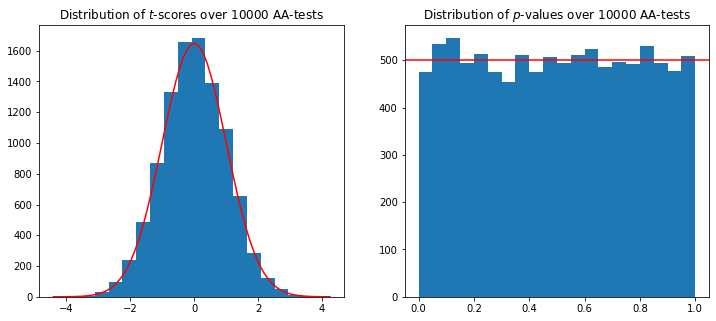

In [33]:
batch_aa_test.display_t_p()

# _Interlude_

Is everything clear so far?

<a name="interlude_1"></a>

[I. How to run a test](#principles)  
[-. _Generate random samples_](#random_generation)  
[II. Process results](#code)  
[III. AA-tests](#aa_test)  
**[IV. Sensitivity testing](#sensitivity)  
[V. Process the source dataset](#source_data)  
[VI. Complications](#unit_selection)  
[_Summary_](#summary)**

# IV. Sensitivity testing

<a name="sensitivity"></a>

Sensitivity tests are AA tests with a boost.

What if, rather than pick two identical samples, we split the sample at random, call on Treatment and then **inflated its conversion rate** by a fraction? Would _that_ make the test more likely to succeed?

## Naive implementation

In [34]:
import copy
thresholds = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]

def find_detected_diff(self, thresholds=thresholds):
    for threshold in thresholds:
        inflated_t_test = copy.deepcopy(self.t_test)
        inflated_t_test.totals.treatment.conversion *= (1+threshold)
        if inflated_t_test.compute():            
            return threshold
    
ABTest.find_detected_diff = find_detected_diff

In [35]:
aa_test = ABTest(events, segment)
aa_test.compute()
aa_test.t_test.significant

False

In [36]:
aa_test.find_detected_diff()

0.5

In [37]:
class SensitivityTest (BatchAATest):

    def run_steps(self, n_runs=100):
        self.list_diff = []
        for j in range(n_runs):
            self.test_with_random_segment()
            self.test.compute()            
            self.test.detected_diff = self.test.find_detected_diff()
            self.list_diff.append(self.test.detected_diff)
        return self.list_diff

In [38]:
sensitivity_test = SensitivityTest(generate_events())
list_diff = sensitivity_test.run_steps()
pd.Series(list_diff).value_counts().sort_index()

0.00    11
0.05     5
0.10    13
0.20    35
0.50    36
dtype: int64

Out of 100 AA-tests on the same `events` data source, we were able to get a significant result by increasing the conversion rate by 5, 10 or 20% — depending on the test split.

### Minimum difference reliably detected

We want to know how much difference between Control and Treatment is large enough to be reliably detected.
We consider that the boost on Treatement large enough to change an AA-test to positive to be a good representation for that.

That value is noisy, therefore we prefer the difference that is large enough to change the test often, _i.e._ the upper quantile of that distribution of differences.

In [39]:
def run_series(self, n_runs=100):
    self.list_diff = self.run_steps(n_runs)
    diff_dist = pd.Series(self.list_diff).value_counts().sort_index()
    zero_ends = pd.Series([0]*len(thresholds), index=thresholds)
    diff_dist.add(zero_ends)
    self.cum_dist = diff_dist.cumsum()
    return self.cum_dist

def run_batch(self, n_runs=100):  
    self.n_runs = n_runs
    self.cum_dist = self.run_series(n_runs)
    self.reliable = int((1-alpha)*n_runs)
    significant = self.cum_dist[self.cum_dist > self.reliable]
    self.min_significant = min(significant.index)
    return self.min_significant

SensitivityTest.run_series = run_series
SensitivityTest.run_batch = run_batch

In [40]:
sensitivity_test.run_batch()

0.5

Let’s output the results in a way that is clearer.

In [41]:
def format_result(self):
    msg = "After {0:,} runs, we estimate that ".format(self.n_runs)
    msg += "this test should reliably ({0:.0%}) detect ".format(1-alpha) 
    msg += "improvements of at least {0:.1%}".format(self.min_significant)
    return msg

SensitivityTest.format_result = format_result

In [42]:
sensitivity_test.format_result()

'After 100 runs, we estimate that this test should reliably (90%) detect improvements of at least 50.0%'

Let’s now plot that distribution.

In [43]:
def display(self):
    val = self.cum_dist.index    
    n_obs = self.test.t_test.observation
    n_clust = len(self.segment)
    fig, ax = plt.subplots()
    str_cond = "({0:,} obs., {1:,} clust.)".format(n_obs, n_clust)
    ax.set(
        title="Sensitivity curve " + str_cond,
        xlabel="Effect scale (log scale)",
        ylabel="Number of tests",
    )    
    ax.plot(self.cum_dist[val > 0])
    ax.set_xscale('log')
    ax.hlines(self.reliable, min(val[val > 0]), max(val),
              color="red", linestyles="dotted")    
    ax.vlines(self.min_significant, 0, self.reliable,
              color="red", linestyles="dotted")    
    plt.show()

SensitivityTest.display = display

After 100 runs, we estimate that this test should reliably (90%) detect improvements of at least 50.0%


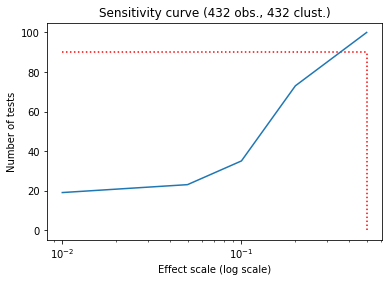

In [44]:
print(sensitivity_test.format_result())
sensitivity_test.display()

This is more granular that it needs to be because we‘ve used sparse `thresholds`.

## Compute minimal difference

We actually do not have to iterate over sample `thresholds` to find the right value for a significant change.

It would be more efficicent to process by dichotomy, either over the list or on absolute values.

More simply, it is faster to run the AA-test; the ratio between the upper bound in real terms and the treatment conversion rate is the smallest effect that would make the test significant.

In [45]:
def find_detected_diff(self):
    min_detection = self.t_test.cr_c + self.t_test.conf_interval[1]
    self.detected_diff = (min_detection/self.t_test.cr_t) - 1
    return self.detected_diff

ABTest.find_detected_diff = find_detected_diff

### Verification

Let’s check that the treatment conversion increased by this minimum boost gives the exact value of the upper limit.

In [46]:
events = generate_events()
segment = generate_segment(events)
aa_test = ABTest(events, segment)
aa_test.compute()
vars(aa_test.t_test)

{'totals': segment    event_type 
 control    conversion     114
            observation    230
 treatment  conversion     117
            observation    214
 Name: user_id, dtype: int64,
 'alpha': 0.1,
 'observation': 444,
 'cr_c': 0.4956521739130435,
 'cr_t': 0.5467289719626168,
 'difference': 0.051076798049573324,
 'rel_diff': 0.10304968027545494,
 'stddev': 0.0473803219471371,
 'z': (-1.6448536269514729, 1.6448536269514722),
 'conf_interval': (-0.07793369440087693, 0.0779336944008769),
 'significant': False,
 'result': 'Draw',
 't': 1.0780171166114159,
 'p': 0.14080704385654585}

That test wasn’t significant, but let’s see if adding the sensitivity to the conversions of Treatment can change that.

In [47]:
import math
sensitivity = aa_test.find_detected_diff()
aa_test.totals.treatment.conversion = math.ceil(
    aa_test.totals.treatment.conversion.astype(float) \
    * (1 + sensitivity))
aa_test.t_test.compute()
vars(aa_test.t_test)

{'totals': segment    event_type 
 control    conversion     114
            observation    230
 treatment  conversion     123
            observation    214
 Name: user_id, dtype: int64,
 'alpha': 0.1,
 'observation': 444,
 'cr_c': 0.4956521739130435,
 'cr_t': 0.5747663551401869,
 'difference': 0.07911418122714342,
 'rel_diff': 0.15961633054599111,
 'stddev': 0.04721204400589949,
 'z': (-1.6448536269514729, 1.6448536269514722),
 'conf_interval': (-0.07765690181889633, 0.07765690181889628),
 'significant': True,
 'result': 'Win',
 't': 1.6757203144447108,
 'p': 0.047250092009473166}

Let’s see how that faster and more accurate approach runs on our sample

In [48]:
sensitivity_test.run_batch(n_runs=500)
print(sensitivity_test.format_result())

After 500 runs, we estimate that this test should reliably (90%) detect improvements of at least 28.4%


That’s faster and offers a less coarse estimate of the actual impact than using `thresholds`.

### Test sensitivity with observations

Let’s now consider an test with more observations than just 1,000.

In [49]:
more_sensitive_test = SensitivityTest(
    generate_events(n_obs=10_000, n_user=5_000))
more_sensitive_test.run_batch(n_runs=500)
print(more_sensitive_test.format_result())

After 500 runs, we estimate that this test should reliably (90%) detect improvements of at least 9.2%


In [50]:
# Warning: This might take several minutes
most_sensitive_test = SensitivityTest(
    generate_events(n_obs=100_000, n_user=50_000))
most_sensitive_test.run_batch(n_runs=500)
print(most_sensitive_test.format_result())

After 500 runs, we estimate that this test should reliably (90%) detect improvements of at least 2.9%


Let’s represent that with a parallels graphs for experiments of each scale.

In [51]:
def multi_display(tests): 
    n_obs = tests[0].test.t_test.observation
    max_val = 0
    fig, ax = plt.subplots()
    ax.set(
        title="Sensitivity curve ({0:,} obs.)".format(n_obs),
        xlabel="Effect scale (log scale)",
        ylabel="Number of tests",
    )    
    for test in tests:
        val = test.cum_dist.index    
        ax.plot(test.cum_dist[val > 0])
        ax.set_xscale('log')
        ax.vlines(test.min_significant, 0, test.reliable,
                  color="red", linestyles="dotted")
        max_val = max(max(val), max_val)
    ax.hlines(test.reliable, min(val[val > 0]), max_val,
              color="red", linestyles="dotted")    
    plt.show()

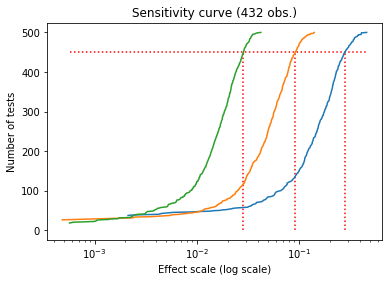

In [52]:
tests = [sensitivity_test, more_sensitive_test, most_sensitive_test]
multi_display(tests)

### Main conclusion

Tests on small samples are **less sensitive** to minor changes.

### Side conclusion

We already knew that testing on smaller samples means our false positive rate $\alpha$ is harder to confirm _cf._ [AA-tests](#aa-test): we can’t control the quality of our tests as well.

Does this mean that **our prediction of the test sensitivity** is less reliable too?

Let’s explore that by running *multiple sensitivity tests* on samples of different sizes.

## Sequence of multiple sensitivity test

In [53]:
def compute_multiple_curves(
    events, n_curve=30, unit="user_id", cluster="user_id"):
    list_sensitivity_test = []
    for i in range(n_curve):
        list_sensitivity_test.append(
            SensitivityTest(events, unit=unit, cluster=cluster))
        list_sensitivity_test[i].run_batch()        
    return list_sensitivity_test

In [54]:
# Warning: This might take several minutes
list_sensitivity_test = compute_multiple_curves(events)

In [55]:
def display_multiple_curves(
    list_sensitivity_test, 
    color="blue", transparency=0.1, 
    padding=1.3, x_scale="linear"
):    
    n_tests = len(list_sensitivity_test)
    n_runs = list_sensitivity_test[0].n_runs
    n_obs = list_sensitivity_test[0].test.t_test.observation
    n_clust = len(list_sensitivity_test[0].segment)

    list_min_significant = []
    for sensitive_test in list_sensitivity_test:
        list_min_significant.append(sensitive_test.min_significant)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram of mininum significant value
    # Titles
    str_cond = "({0:,} obs., {1:,} clust.)".format(n_obs, n_clust)
    ax1.set(
        title="{0:,} sensitivity tests ".format(n_tests) + str_cond,
        xlabel="Difference size",
        ylabel="Number of AA-tests",
    )    
    # Scale
    if x_scale == "linear":
        x_lim = (0, max(list_min_significant)*padding)
        ax1.set_xlim(x_lim)
    if x_scale == "log":        
        ax1.set_xscale('log')
        x_lim = (val[val > 0], max(val))
        ax1.set_xlim(x_lim)
    ax1.hlines(
        list_sensitivity_test[0].reliable, x_lim[0], x_lim[1],
        color="red", linestyles="dotted"
    )

    # Iterate on each sensitivity curve
    for sensitive_test in list_sensitivity_test:
        cum_dist = sensitive_test.cum_dist
        val = cum_dist.index
        use = (val > x_lim[0]) & (val < x_lim[1])
        ax1.plot(cum_dist[use], color=color, alpha=transparency)
    x_ticks = ax1.get_xticks()
    ax1.set_xticklabels(['{:,.0%}'.format(x) for x in x_ticks])
    
    # Histogram of mininum significant value
    ax2.hist(list_min_significant)
    x_ticks = ax2.get_xticks()
    ax2.set_xticklabels(['{:,.0%}'.format(x) for x in x_ticks])
    # Density curve of sensitivity
    x = np.linspace(min(x_ticks), max(x_ticks), 20)
    m = np.mean(list_min_significant)
    s = np.std(list_min_significant)
    ax2.plot(x, norm.pdf(x, m, s)*n_tests*s/2)
    ax2.set(
        title="Minimum difference reliably detectable",
        xlabel="Reliably ({0:.0%}) detectable difference".format(1-alpha),
        ylabel="Number of Sensitivity tests",
    )    
    plt.show()

### How sensitive is a test on 1,000 observations and 500 users?

<a name="sensitive_1000"></a>

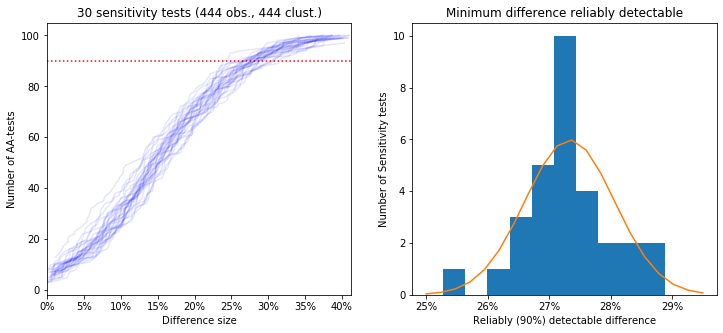

In [56]:
display_multiple_curves(list_sensitivity_test)

We can reliably detect the impact of a treatement if it’s at least **25% to 30%.**  
Remember that estimation: we’ll need it in 5 minutes.

### How sensitive is a test on 200 observations and 100 users?

In [57]:
# Warning: This might take several minutes
list_less_sensitive_test = compute_multiple_curves(
    generate_events(n_obs=200, n_user=100))

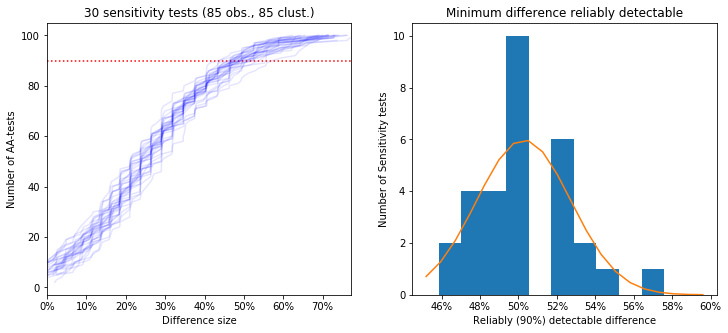

In [58]:
display_multiple_curves(list_less_sensitive_test)

This is a _lot_ less sensitive. That’s why it’s not seen as very useful at this scale.

# V. Processing the source dataset

<a name="source_data"></a>


## Aggregating small samples gracefully

Let’s take an extreme example (20 observations, 20% conversion rate) and see how our code fails on such a small sample.

In [59]:
def try_small_sample(cr=.4, n_obs=50):
    events = generate_events(cr=cr, n_obs=n_obs)
    batch_aa_test = BatchAATest(events)
    try:
        batch_aa_test.run_series(n_runs=50)
        batch_aa_test.compute_alpha_ci()
        batch_aa_test.display_alpha_ci()
    except Exception as e:
        print(type(e).__name__, e)
        print(batch_aa_test.test.totals)

In [60]:
try_small_sample(cr=.2, n_obs=15)

AttributeError 'Series' object has no attribute 'conversion'
segment    event_type 
control    conversion      4
           observation    11
treatment  observation     4
Name: user_id, dtype: int64


### Introduce data quality tests

If `n_user < 100`, then random segments might not include both active users assigned to `control` or `treatment`. We want to check that there are enough in both segments to run a test.

In [61]:
def is_segment_balanced(self, min_ratio=.4):    
    try:
        oc = self.totals.control.observation
        ot = self.totals.treatment.observation
        min_ratio = (oc + ot) * min_ratio
        balanced = (min(oc, ot) >= min_ratio)
      
        cc = self.totals.control.conversion
        ct = self.totals.treatment.conversion
        conversion_exist = (cc > 0) & (ct > 0)
        
        self.balanced = balanced & conversion_exist
    except:
        self.balanced = False
    return self.balanced

ABTest.is_segment_balanced = is_segment_balanced

In [62]:
def test_with_random_segment(self, verbose=False):
    self.balanced = False
    while self.balanced is False:
        self.segment = generate_segment(
            self.events, cluster=self.cluster)
        self.test = ABTest(
            self.events, self.segment,
            unit=self.unit, cluster=self.cluster)        
        self.test.compute()
        self.balanced = self.test.is_segment_balanced()
        if verbose and not self.balanced:
            print("Segment not balanced", self.test.totals)
    self.test.t_test = TTest(self.test.totals)
    self.test.t_test.compute()
    self.test.decision = self.test.t_test.format_decision()
    return self.test

BatchAATest.test_with_random_segment = test_with_random_segment
SensitivityTest.test_with_random_segment = test_with_random_segment

In [63]:
try_small_sample()

We measure a false positive rate between 7.5% and 18.5%.
This is consistent with our rate set at 10.0%. 


### Issue with small samples

1. Less sensitive overall: use observations as a Bayesian update
1. Less able to check for sensitivity and false positives
1. There might not be 10,000 good, possible random samples


Tests on samples as small as 20 (to be split in two) have terrible behaviour.

That notwithstanding, the new method `BatchAATest.test_with_random_segment()` iterates until we had segments that respect basic rules (`balanced` and `conversion_exist`).

If our constraints on segment are more constrained, we can reject some randomised splits to make sure the test is sensical. Let’s see what those constrained can be in practice.

# VI. Complications

<a name="unit_selection"></a>

Identifying the test _unit_ is the least obvious difficulty.

## Clusters of uneven scale

Imagine you are testing an over-the-line (OTL) adverting campaign: posters on bus stops and on buses. This can only be done per city. An large number of city doesn’t means the sample is balanced.

Imagine you have 10,000 users to split, but they also live in one of 100 cities. You want to make sure the distribution in each segment per city is reasonnable. However, the number of users per city is very disparate. In practice, it often follows a Zipf’s law.

What’s the impact of re-balancing on sensitivity?

Let's generate users attributed to a city, according to a Zipfian law.

In [64]:
def generate_user_city(n_user=10_000, n_city=100, zipf_zeta=1.23):
    """
    Given optional key counts about users and city
    Return a random Zipfian pairwise attribution of users to cities 
    """
    user_city = pd.DataFrame(np.random.zipf(zipf_zeta, n_user))
    overshoot = (user_city > n_city)
    replacements = sum(overshoot)
    while replacements > 0:
        user_city[overshoot] = np.random.zipf(2, replacements)
        new_overshoot = (user_city > n_city)
        replacements = sum(new_overshoot)
        overshoot = new_overshoot        
    user_city.rename(columns={0: 'city_id'}, inplace=True)
    user_city.index.name = "user_id"
    return user_city

In [65]:
def generate_events_with_city(
    n_user=10_000, n_obs=1_000, n_city=100,
    cr=.3, pp=.4, zipf_zeta=2
):
    """
    Given optional counts of users and city and parameters
    Return a random set of events done by users in cities 
    """
    events = generate_events(cr=cr, n_obs=n_obs, n_user=n_user, pp=pp)
    user_city = generate_user_city(
        n_user=n_user, n_city=n_city, zipf_zeta=zipf_zeta)
    events = events.join(user_city, on="user_id")
    return events

By default, we use the most cited estimation of $\zeta\approx1.23$ but for this example we want a more extreme case and use a very infair distribution of $\zeta=2$ 

In [66]:
events = generate_events_with_city(zipf_zeta=2)
segment = generate_segment(events, cluster="city_id")
events_with_segment = events.set_index("city_id")\
    .join(segment, on="city_id")
totals = events_with_segment\
    .groupby(["segment", "event_type"])["segment"].count()

In [67]:
totals

segment    event_type 
control    conversion      62
           observation    198
treatment  conversion     249
           observation    802
Name: segment, dtype: int64

Those are very unbalanced.

If the largest city happens to be in one segment, that segment will have a lot more observations.

In [68]:
observation = (events_with_segment["event_type"] == "observation")
city_segment_obs = events_with_segment[observation]\
    .groupby(["city_id", "segment"])["segment"].count()
city_segment_obs.head(15)

city_id  segment  
1        treatment    603
2        treatment    167
3        control       69
4        control       37
5        control       17
6        control       16
7        control       18
8        control       11
9        treatment      8
10       treatment      3
11       treatment      4
12       control        5
13       control        2
15       control        2
16       control        2
Name: segment, dtype: int64

## Sensitivity of uneven clusters

Is this making false positive more common? Blunting the test sensitivity?  
Can we circumvent it while still respecting the constraint of cities as clusters?

In [69]:
cluster_aa_test = BatchAATest(events, cluster="city_id")
cluster_aa_test.run_series()
cluster_aa_test.compute_alpha_ci()
cluster_aa_test.display_alpha_ci()

We measure a false positive rate between 0.0% and 0.0%.
This is not consistent with our rate set at 10.0%. 


False

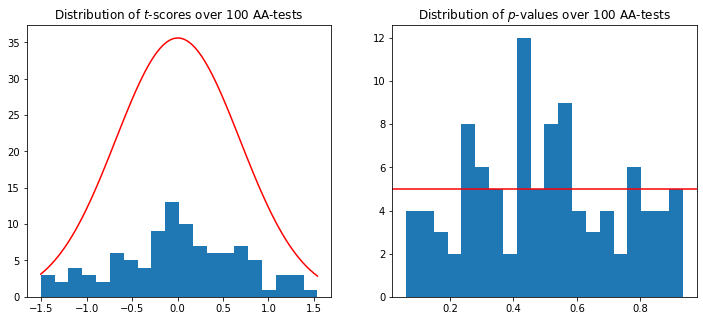

In [70]:
cluster_aa_test.display_t_p()

In [71]:
cluster_sensitivity = SensitivityTest(events, cluster="city_id")
cluster_sensitivity.run_batch()
print(cluster_sensitivity.format_result())

After 100 runs, we estimate that this test should reliably (90%) detect improvements of at least 39.1%


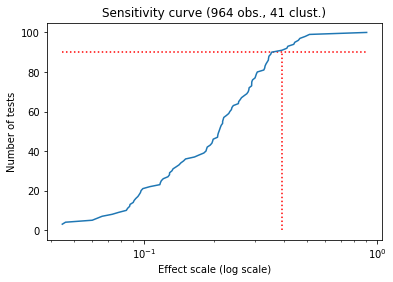

In [72]:
cluster_sensitivity.display()

This doesn’t seem to be circumstances conductive to sensitive tests.  
Let’s confirm that over several sensitivity tests.

In [73]:
# Warning: This might take several minutes
list_cluster_sensitivity_tests = \
    compute_multiple_curves(events, cluster="city_id")

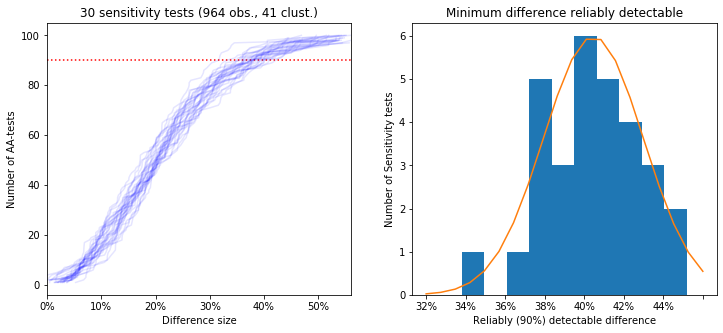

In [74]:
display_multiple_curves(list_cluster_sensitivity_tests)

An [earlier look](#sensitivity_1000) into a test on a similar sample of 1,000 observations lead to a sensitivity around 25% to 30%. With an unbalanced clustering, we more that to 36% to 46%, more than double — a far worse sensitivity. Let’s remember that interval.

Would removing the main city to rebalance the samples help with either the imbalance of the test or its sensitivity?

## Experiment improvement approaches

What can we do to improve the sensitivity of an experiment, given a set of observations and contraints on segmentatation?

We want to try to modify our segment generation to improve the test.  
Whether they actually improve the sensitivity is to be verified by running:
- several Sensitivity tests to draw a bundle of (30) curves;
- each curve correspond to a batch of (100) AA-tests,  
  that were modified to reveal how much changes could flip them;
- all (of 3,000) AA-tests use the same `events` but  
  each of them `segment` them in `control` and `treatment` differently.

Therefore we need to run that process `compute_multiple_curves()` twice:
1. once with a `SensitivityTest.test_with_random_segment()` method that is constrained, restarted, optimised for considerations like `balance`;
1. once where it’s not.

### Exclusion

Would removing the largest cluster allow us to re-balance our sample?

In [75]:
# Warning: This might take several minutes
events_beheaded = events[events["city_id"]!=1]
list_behaded_sensitivity_tests = \
   compute_multiple_curves(events_beheaded, cluster="city_id")

This is equivalent to modifying `SensitivityTest.test_with_random_segment()` so that it always assigns the `city_id=1` to the segment `None`: 

``` python
def test_with_random_segment(self):
    self.segment = generate_segment(self.events)
    self.segment.loc[[1], "segment"] = None
    self.test = ABTest(self.events, self.segment)
    self.test.compute()
    return self.test

SensitivityTest.test_with_random_segment = test_with_random_segment
```

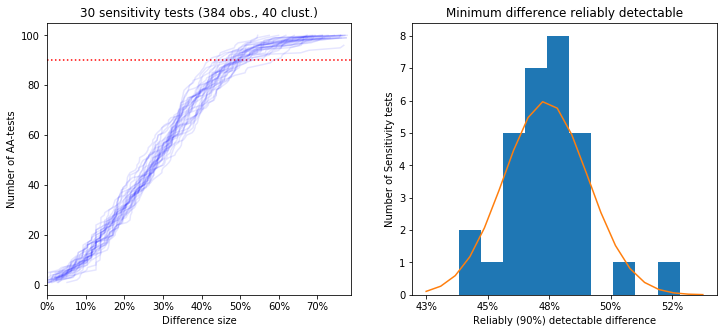

In [76]:
display_multiple_curves(list_behaded_sensitivity_tests)

A sensitivity of 45 to 50% is worse that the sensitivity of the test including the main city (36% to 46%).  
Far from improving, removing large cluster makes the test less sensitive.

### Segment assignment by school-yard picking 

Would assigning each city in descending size order to the smallest segment improve our sensitivity?

It would make the `segment`s very similar to one another.  
This would remove the randomisation that is essential to the technique.

### Swaps

If we want to make sure that a sample is more balanced, we can re-assign one cluster to the other segment to improve the inequality. You now have the ability to implement such an algorithm `__swap__` and test if it increases sensitivity of your experiment. 

```python
def test_with_random_segment(self, verbose=False):
    self.balanced = False
    while self.balanced is False:
        self.segment = generate_segment(
            self.events, cluster=self.cluster)
        self.test = ABTest(
            self.events, self.segment,
            unit=self.unit, cluster=self.cluster)        
        self.test.compute()
        self.balanced = self.test.is_segment_balanced()
        if not self.balanced:
            self.segment = __swap__(self.segment)
            if verbose:
                print("Segment not balanced", self.test.totals)            
    self.test.decision = self.test.t_test.format_decision()
    return self.test

BatchAATest.test_with_random_segment = test_with_random_segment
SensitivityTest.test_with_random_segment = test_with_random_segment
```

## User engagement level

Most web-based activity logs presents the same latent dimension: engagement. Some users come often, contribute a lot to the business model. It often happens that their conversion rate _per session_ is lower because they convert often but they connect more often.

More generally, this means that, if one dimension used for the segment assigment (user) can be correlated to the unit (conversion per session) then we have [problematic tests](https://towardsdatascience.com/the-second-ghost-of-experimentation-the-fallacy-of-session-based-metrics-fb65006d30ff).

If that’s the case, the test is biased: we need to either use a metric based on the same observation as our assigment mechanism.

_TBC_

### Clusters unbalanced per known type

Imagine that you have two types of customers, with different conversion ratio. Those types are not present in the same ratio in your clusters. 

_TBC_

### Clusters unbalanced per hidden type

Imagine now that we can’t tell which user is which.

_TBC_

Let’s breakdown the process

<!-- Run comparative `compute_multiple_curves` using the `test_with_random_segment` function as parameter. -->

In [77]:
alternative_tuple = ("control", "treatment")

def get_unbalalance(events, segment, cluster):

def find_best_reassign(events, segment, cluster, alt=alternative_tuple):
    # Measuring asymetry
    #self.#
    events_with_segment = events.set_index(cluster)\
        .join(segment, on=cluster)   
    #self.#
    cluster_segment_obs = events_with_segment[observation]\
        .groupby([cluster, "segment"])["segment"].count()
    #self.#
    unbalance = cluster_segment_obs.groupby(["segment"]).sum()    
    # # # # # # # # # # # # # # # # # # # # 
    # if len(unbalance) < 2:
    #     return generate_segment(events)
    # print("Green")
    # print(len(unbalance))
    # print("Green")
    # # # # # # # # # # # # # # # # # # # # 
    # Direction
    shift_needed = (unbalance[alt[1]] - unbalance[alt[0]])/2
    if shift_needed > 0:
        destination, source = alt
    else:
        source, destination = alt
    source_position = cluster_segment_obs.index.isin([source], level=1)
    possible_source = cluster_segment_obs.iloc[source_position]
    proximity_ideal = abs(possible_source - abs(shift_needed))
    best_source = proximity_ideal.values.argmin()
    return best_source, unbalance, 

# Reassignment
segment.loc[best_source, "segment"] = destination


IndentationError: expected an indented block (<ipython-input-77-ac9afc6b43bf>, line 5)

In [ ]:
print(segment.head())
new_segment = reassign_one_cluster(events, segment, cluster="city_id")
print(new_segment.head())

In [ ]:

def test_with_random_segment(self, verbose=True):   
    def reassign(segment):
        return reassign_one_cluster(
            self.events, segment, cluster="city_id")
    def segment_balance(segment):
        test = ABTest(self.events, segment)        
        test.totals = compute_totals(self.events, segment)
        return balance(test.totals)       
    segment = generate_segment(self.events)
    possible_improvement = True
    while possible_improvement:
        new_segment = reassign(segment)        
        old_balance = segment_balance(segment)
        new_balance = segment_balance(new_segment)
        possible_improvement = (new_balance > old_balance)
        if possible_improvement:
            segment = new_segment
            if verbose:
                print("Swap one")
                print(segment.head())
    self.segment = segment    
    self.test = ABTest(self.events, self.segment)        
    self.test.totals = compute_totals(self.events, self.segment)
    self.test.t_test = TTest(self.test.totals)
    self.test.t_test.compute()
    self.test.decision = self.test.t_test.format_decision()
    return self.test

SensitivityTestWithReassigment = SensitivityTest
SensitivityTestWithReassigment\
    .test_with_random_segment = test_with_random_segment    

In [ ]:
sensitivity_test = SensitivityTestWithReassigment(events)
sensitivity_test.run_batch()

### Scale as a category

What if users from large cities behave differently than users from smaller ones?

# _Interlude_

Is everything still clear?

<a name="interlude_2"></a>

[I. How to run a test](#principles)  
[-. _Generate random samples_](#random_generation)  
[II. Process results](#code)  
[III. AA-tests](#aa_test)  
[IV. Sensitivity testing](#sensitivity)  
[V. Process the source dataset](#source_data)  
**[VI. Complications](#unit_selection)  
[_Summary_](#summary)**


## Unit selection with AA tests


### Choosing a test unit on web traffic: observation, session, user, country

Our `event` only knows about `user_id`.

Let’s see what happens when we include realistic observations, session and countries in addition to users. 

In [ ]:
def generate_session(cr=.3, pp_n=.9, pp_d=.6):
    n_obs_session = int(np.random.pareto(pp_n)+1)
    delays = pd.Series(np.random.pareto(pp_d, size=(n_obs_session)))
    delays = delays.cumsum()
    conversions = pd.Series(np.random.rand(n_obs_session) < cr/np.sqrt(n_obs_session))
    conv_delays = pd.Series(np.random.pareto(pp_d, size=(n_obs_session)))
    session = pd.concat([delays, conversions, conv_delays], axis=1, sort=False)
    session.columns = ["event_delay", "conversion", "conversion_delay"]
    return session

def generate_session_basic(n_session=500, n_user=500):
    dates = pd.Series(np.random.random(size=(n_session)))
    dates = dates.apply(date_from_value)
    users = pd.Series(np.random.randint(n_user, size=(n_session)))    
    sessions = pd.concat([dates, users], axis=1, sort=False)
    sessions.columns = ["event_timestamp", "user_id"]
    return sessions

In [ ]:
def generate_session_detail(
    n_session=500, n_user=500,
    cr=.3, pp_n=.95, pp_d=.7
):
    sessions = generate_session_basic(n_session, n_user)
    col_sess = ["event_timestamp", "user_id", "session_id", "event_type"]
    sessions_detailed = pd.DataFrame([], columns=col_sess)
    for index, row in sessions.iterrows():
        session_events = generate_session(cr=cr, pp_n=pp_n, pp_d=pp_d)
        n = len(session_events)
        session_events["user_id"] = row["user_id"]
        session_events["session_id"] = index
        session_start_time = row["event_timestamp"]        
        session_events["event_timestamp"] = \
            session_events["event_delay"].apply(
                lambda x: session_start_time + dt.timedelta(minutes=x))        
        session_events = pd.DataFrame(session_events)

        conversions = generate_conversion_from_observation(session_events)
        observation = session_events[["event_timestamp", "user_id", "session_id"]]
        observation = observation.assign(event_type = "observation")
        conversions = conversions.assign(event_type = "conversion")
        events = pd.concat([observation, conversions], axis=0, sort=False)    
        sessions_detailed = sessions_detailed.append(
            events, ignore_index=True, sort=False)
    sessions_detailed.sort_values("event_timestamp")        
    return sessions_detailed

In [ ]:
def generate_session_city(
    n_session=1_000, n_user=2_000, n_city=100,
    cr=.3, pp_n=.95, pp_d=.7, zipf_zeta=2
):
    """
    Given optional counts of users and city and parameters
    Return a random set of events done by users in cities 
    """
    session = generate_session_detail(
        n_session=n_session, n_user=n_user,
        cr=cr, pp_n=pp_n, pp_d=pp_d
    )
    user_city = generate_user_city(
        n_user=n_user, n_city=n_city, zipf_zeta=zipf_zeta)
    session_city = session.join(user_city, on="user_id")
    return session_city    

In [ ]:
session_detail = generate_session_city(n_session=5, n_user=5)
session_detail

## Identification after the fact
<a name="id_post_exposure"></a>

Imagine some users go through the site without identification. They are treated as a distinct users first, and could be exposed to another experience. This raises concerns: they might prefer consistency in their user experience.

Using smaller or more units, like any users without cookies, can increase the number of units and the sensitivity of the test, but it might also increase the number of users who prove to have seen for experience after the fact.

In [ ]:
session_detail = generate_session_city(n_session=50, n_user=50)

In [ ]:
def generate_users_log_in_after_fact(
        session_detail, logged_in=0.5, unit="user_id"
):
    user_first_session = session_detail.groupby(unit)["event_timestamp"].min()
    user_first_session = pd.DataFrame(user_first_session)
    n_user_session = max(user_first_session.index) + 1
    user_first_session["logged_in"] = \
        pd.Series(np.random.rand(n_user_session) < logged_in)
    users_logged_in = (user_first_session["logged_in"])
    n_logged_in = int(sum(users_logged_in))
    revelation = pd.DataFrame(
        np.random.choice(users_logged_in.index, n_user_session),
        columns=["alt_user_id"]
    )
    user_first_session = user_first_session.join(revelation, on=unit)
    alt_first_session = user_first_session
    alt_first_session.index.name = "alt_user_id" # , "alt_timestamp", "alt_logged_in"]
    user_first_session = user_first_session.join(
        alt_first_session, on="alt_user_id")
    print(user_first_session)

    # user_first_session[~users_logged_in]["actual_user"] = revelation
    return user_first_session.head(10)
    # user_first_session[]["actual_user"] = revelation
    #session_detail.join(user_first_session, on=unit)
    
# Randomly assign by default 50% of users to another user.

# events["actual_user"]
# exclude actual_user from possible re-assignments

In [ ]:
generate_users_log_in_after_fact(session_detail)

### Double-exposure

Users who have seen both option might have gone through a unusual experimence. In that case, we prefer to exclude them as it’s unclear which experience they’d represent. Let’s measure how common that is.

In [ ]:
def generate_events_with_duplicates(cr, n_users, n_obs, logged_in=0.5):
    generate_events(cr, n_users, n_obs)
    generate_events[] random. logged_in
    ### count double-exposed users — as a function of ratio of not-logged-in

This exclusion can introduce bias; _e.g._ if they have to re-connect and might not remember their password —which is common when doing secure operations like paying— could be exposed; that means users are more likely to be double-exposed if the experience that they are exposed increase the likelihood of, say, paying. Or less likely if they are able to avoid complications during the operation.

In [ ]:
def exclude_double_exposure(events):
    user_ids = events.groupby(["actual_user"])["segment"].nunique()
    double_exposed = (user_ids["count"] > 1)
    events_duplicates = events["actual_user"].isin(double_exposed.index)
    events_without_duplicates = events[~events_duplicates].dropna() 
    return events_without_duplicates

This reduces significance if you have a large number of non-logged in users.

# VII. Overlapping experiments

<a name="overlap"></a>

## Simulating the risk of overlap

_TBD_

## Detecting interference and exclusion

_TBD_

## Multi-variate testing (MVT)

<a name="multi-variate_test"></a>

Distinct from (additive) multi-variable test: ABC-test.

_TBD_

Multiplicative: A-A', A-B', B-A', B-B'.
Four way test? Detect significant difference between (A * A') and A-A'

# _Summary_
<a name="summary"></a>

You can test on small samples, but it’s less sensitive:
- run extensive AA- and  **Sensitivity tests**;
- swap or exclude clusters to **optimise** might not work as expected;
- consider the **relevant unit** and cluster carefully;
- **control** for activity, type.

[I. How to run a test](#principles)  
[-. _Generate random samples_](#random_generation)  
[II. Process results](#code)  
[III. AA-tests](#aa_test)  
[IV. Sensitivity testing](#sensitivity)  
[V. Process the source dataset](#source_data)  
[VI. Complications](#unit_selection)  
[_Summary_](#summary)

# References 
## Implementing AB-tests

- [Detailed advice on common testing issues](https://towardsdatascience.com/chasing-statistical-ghosts-in-experimentation-3f393323a1c1) from Lizzie Eardley,  
  with Colin McFarland and Tom Oliver of SkyScanner;
- [Guidelines for AB testing](https://robinsones.github.io/Guidelines-for-AB-Testing/) from Emily Robinson of Etsy and DataCamp;
- [Fully detailed code](https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f) from Nguyen Ngo of TowardsDataScience;
- Arguments for [a Bayesian approach](https://medium.com/convoy-tech/the-power-of-bayesian-a-b-testing-f859d2219d5) from Michael Frasco of Convoy and  
  for [a mixed frequentist and Bayesian approach](https://www.convertize.com/ab-test-significance/) from Philippe Aimé of Convertize

## Theory on causal models
- [Class video on Causal inference](https://www.youtube.com/watch?v=vGcWJcgY-MY) from Kari Lerum of Uni. of Washington
- [Class slides on Causal inference](https://imai.fas.harvard.edu/talk/files/Taiwan14.pdf) from Kosuke Imai of Princeton
- [Detailed tutorial on non-parametric causal models](https://www.youtube.com/watch?v=FBiBA1uV8Dk) from Thomas Richardson of Uni. of Washington at NeurIPS 2016

# Appendix

In [ ]:
# Strong typing
class TypedDataFrame:
    def __init__(self, table):
        self.col_names = None
        self.col_types = None
        self.df = table
    def specify_type(self):
        self.df = pd.DataFrame(self.table, columns=self.col_names)
        for i, col_name in enumerate(self.col_names):
            self.df[col_name].astype(self.col_types[i])

class Events(TypedDataFrame):
    def __init__(self, table):
        self.col_names = ["event_timestamp", "user_id", "event_type", ]
        self.col_types = ['datetime64', 'int', 'category', ]        
        self.specify_type()
    def random_populate(sample_size, p):
        self.df = generate_events()

class Segment(TypedDataFrame):
    def __init__(self, table):
        self.cols = ["timestamp_attribution", "segment", ]
        # user_id is key
        self.col_type = ['datetime64', 'category', ]        
        self.specify_type()
    def random_populate(events, options):
        self.df = generate_segment(events, options)

###  Unbalanced samples

Let’s use a standard definition for balanced repartition.

In [ ]:
def gini_index(totals):
    co = totals.control.observation
    to = totals.treatment.observation
    return abs(co-to)/(co+to)

In [ ]:
gini_index(totals)